In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)
import altair as alt

In [ ]:
alt.data_transformers.enable('default')
alt.data_transformers.disable_max_rows()

alt.renderers.enable('colab')

RendererRegistry.enable('colab')

In [ ]:
print('Downloading movielens data...')
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', 'r')
zip_ref.extractall()
print('Done. Dataset contains:')
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [ ]:
# Load masing masing dataset (users, movies, and ratings)
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep = '|', names=users_cols, encoding = 'latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# Genre pada setiap film bersifat biner.
genre_cols = [
    'genre_unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mistery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

movie_cols = [
    'movie_id', 'tittle', 'release_date', 'video_release_date', 'imdb_url'
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movie_cols, encoding= 'latin-1')
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [ ]:
print('Jumlah data film : ', len(movies.movie_id.unique()))
print('Jumlah data pengunjung : ', len(users.user_id.unique()))
print('Jumlah data penayangan : ', len(ratings.user_id))

Jumlah data film :  1682
Jumlah data pengunjung :  943
Jumlah data penayangan :  100000


In [ ]:
users['user_id'] = users['user_id'].apply(lambda x: str(int(x) -1))
movies['movie_id'] = movies['movie_id'].apply(lambda x: str(int(x) -1))
movies['year'] = movies['release_date']. apply(lambda x: str(x).split('-')[-1])
ratings['movie_id'] = ratings['movie_id'].apply(lambda x: str(x-1))
ratings['user_id'] = ratings['user_id'].apply(lambda x: str(x-1))
ratings['rating'] = ratings['rating'].apply(lambda x: float(x))

In [ ]:
genre_occurences = movies[genre_cols].sum().to_dict()
genre_occurences

{'genre_unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 'Children': 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mistery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [ ]:
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres , gs) if g==1]
    if len(active) == 0:
        return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g ==1]
    if len(active) == 0:
        return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [ ]:
movies['all_genres']

,all_genres
0,Animation-Children-Comedy
1,Action-Adventure-Thriller
2,Thriller
3,Action-Comedy-Drama
4,Crime-Drama-Thriller
...,...
1677,Drama
1678,Romance-Thriller
1679,Drama-Romance
1680,Comedy


In [ ]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [ ]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
    """returns a filtered dataframe, by applying function to key"""
    return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [ ]:
users.describe(include='all')

,user_id,age,sex,occupation,zip_code
count,943,943.000,943,943,943
unique,943,NaN,2,21,795
top,942,NaN,M,student,55414
freq,1,NaN,670,196,9
mean,NaN,34.052,NaN,NaN,NaN
...,...,...,...,...,...
min,NaN,7.000,NaN,NaN,NaN
25%,NaN,25.000,NaN,NaN,NaN
50%,NaN,31.000,NaN,NaN,NaN
75%,NaN,43.000,NaN,NaN,NaN


In [ ]:
# Hitung jumlah rating dan rata-rata rating per user
user_summary = ratings.groupby('user_id')['rating'].agg(
    rating_count='count',
    rating_mean='mean'
).reset_index()

# Gabungkan dengan data user (untuk dapat kolom occupation)
users_ratings = pd.merge(user_summary, users, on='user_id')


In [ ]:
# Membuat filter untuk melakukan slicing data
occupation_filter = alt.selection_multi(fields=['occupation'])
occupation_chart = alt.Chart().mark_bar().encode(
    x = 'count()',
    y = alt.Y('occupation:N'),
    color = alt.condition(
        occupation_filter,
        alt.Color('occupation:N', scale=alt.Scale(scheme='category20')),
        alt.value('lightgray')),
).properties(width=300, height=300, selection=occupation_filter)

# Fungsi yang dapat membuat histogram dari data yang sudah difilter
def filtered_hist(fieled, label, filter):
  base = alt.Chart(users_ratings).mark_bar().encode(
      x=alt.X(fieled, bin=alt.Bin(maxbins=10), title=label),
      y='count()',
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

/tmp/ipython-input-2518908715.py:2: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  occupation_filter = alt.selection_multi(fields=['occupation'])


In [ ]:
occupation_filter = alt.selection_point(fields=['occupation'])
occupation_chart = alt.Chart(users_ratings).mark_bar().encode(
    x='count()',
    y=alt.Y('occupation:N'),
    color=alt.condition(
        occupation_filter,
        alt.Color('occupation:N', scale=alt.Scale(scheme='category20')),
        alt.value('lightgray')),
    ).add_params(occupation_filter)  # Move selection here

# ... (Rest of your code remains the same)
# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating_count', '#ratings / user', occupation_filter),
    filtered_hist('rating_mean', 'mean user rating', occupation_filter),
    occupation_chart)

alt.HConcatChart(...)

In [ ]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating' : ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')
genre_filter = alt.selection_point(fields=['genre'])
genre_chart = alt.Chart(movies_ratings).mark_bar().encode(
    x='count()',
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color('genre:N'),
        alt.value('lightgray'))
).properties(height=300).add_selection(genre_filter)  # add selection here
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating_count', '# ratings / movie', genre_filter),
    filtered_hist('rating_mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

/tmp/ipython-input-1052968573.py:15: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).properties(height=300).add_selection(genre_filter)  # add selection here


alt.HConcatChart(...)

In [ ]:
(movies_ratings[['tittle', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=True)
 .head(10))

,tittle,rating count,rating mean
1672,Mirage (1995),1,3.000
1681,Scream of Stone (Schrei aus Stein) (1991),1,3.000
1670,"Further Gesture, A (1996)",1,1.000
1669,Tainted (1998),1,3.000
1668,MURDER and murder (1996),1,2.000
1667,Wedding Bell Blues (1996),1,3.000
1636,Girls Town (1996),1,3.000
1635,Brothers in Trouble (1995),1,4.000
1634,Two Friends (1986),1,3.000
1633,Etz Hadomim Tafus (Under the Domin Tree) (1994),1,2.000


In [ ]:
(movies_ratings[['tittle', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x> 20)
 .sort_values('rating mean', ascending=False)
 .head(10))


,tittle,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466
168,"Wrong Trousers, The (1993)",118,4.466
482,Casablanca (1942),243,4.457
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.448
63,"Shawshank Redemption, The (1994)",283,4.445
602,Rear Window (1954),209,4.388
11,"Usual Suspects, The (1995)",267,4.386
49,Star Wars (1977),583,4.358
177,12 Angry Men (1957),125,4.344


In [ ]:
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [ ]:
# kelas untuk melatih model faktorisasi matriks menggunakan penurunan gradien stokastik
class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self.embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations= []
      metrics = self._metrics or({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print('\r iteration %d: '% i + ', '.join(
              ['%s=%f' % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self.embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
def build_model(ratings, embedding_dim, init_stddev):
  # Membagi dataset menjadi data latih dan uji
  train_ratings, test_ratings = split_dataframe(ratings)
  # Mengubah dataset menjadi SparseTensor
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Inisialisasi embedding menggunakan distribusi normal
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev = init_stddev))
  V = tf.Variable(tf.random_normal(
                  [A_train.dense_shape[1], embedding_dim], stddev = init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error' : train_loss,
      'test_error' : test_loss
  }
  embeddings = {
      'user_id' : U,
      'movie_id' : V
  }
  return CFModel(embeddings, train_loss, [metrics])

 iteration 1000: train_error=0.374564, test_error=1.368517

[{'train_error': np.float32(0.37456396), 'test_error': np.float32(1.3685172)}]

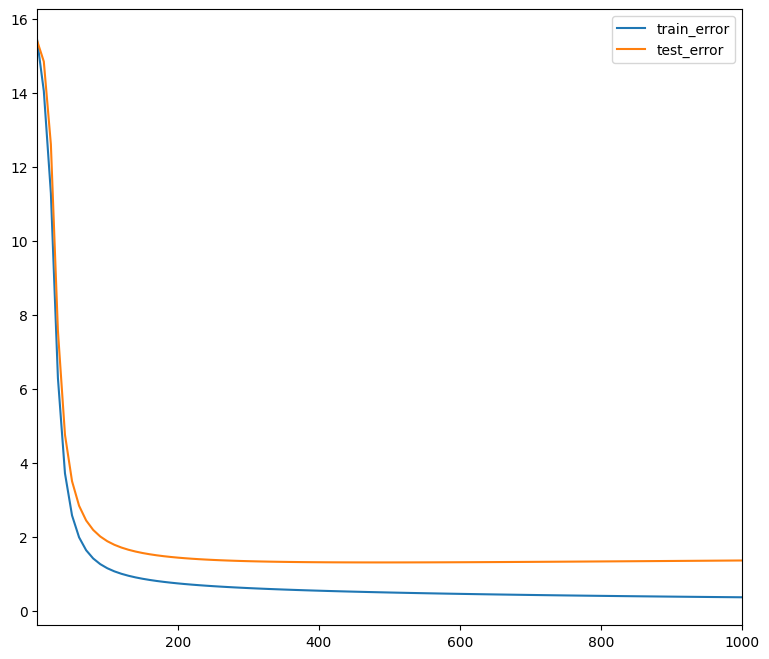

In [ ]:
model = build_model(ratings, embedding_dim =30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure = DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [ ]:
def user_recommendations(model, measure=DOT, exclude_rated=True, k=6):
  if users_ratings:
    scores = compute_scores(
        model.embeddings['user_id'][942], model.embeddings['movie_id'], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key : list(scores),
        'movie_id' : movies['movie_id'],
        'titles' : movies['tittle'],
        'genres' : movies['all_genres'],
    })
    if exclude_rated:
      # Menghapus film yang sudah diberikan rating oleh user.
      rated_movies = ratings[ratings.user_id == '942']['movie_id'].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id  not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
users_ratings = True
user_recommendations(model, measure=COSINE, k=5)
user_recommendations(model, measure=DOT, k=5)


,cosine score,movie_id,titles,genres
237,0.747,237,Raising Arizona (1987),Comedy
662,0.737,662,Being There (1979),Comedy
435,0.706,435,"American Werewolf in London, An (1981)",Horror
835,0.670,835,Ninotchka (1939),Comedy-Romance
481,0.656,481,Some Like It Hot (1959),Comedy-Crime


,dot score,movie_id,titles,genres
662,6.850,662,Being There (1979),Comedy
835,6.849,835,Ninotchka (1939),Comedy-Romance
18,6.176,18,Antonia's Line (1995),Drama
701,6.135,701,Barcelona (1994),Comedy-Romance
114,6.046,114,"Haunted World of Edward D. Wood Jr., The (1995)",Documentary


membuat rekomendasi berdasarkan kemiripan genre dari masing-masing film

In [ ]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Mencari film berdasarkan judul yang dimasukkan
  ids = movies[movies['tittle'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['tittle'].values
  if len(titles) == 0:
    raise ValueError('Found no movies with title%s' % title_substring)
  print('Nearest neighbors of : %s.' % titles[0])
  if len(titles) > 1:
    print('[Found more than one matching movie. Other candidates: {}]'.format(
        ', '.join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings['movie_id'][movie_id], model.embeddings['movie_id'], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key : list(scores),
      'titles' : movies['tittle'],
      'genres' : movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

memberikan rekomendasi kepada pengguna berdasarkan genre dari judul film yang pernah ditonton

In [ ]:
movie_neighbors(model, 'Star Wars', DOT)
movie_neighbors(model, 'Star Wars', COSINE)

Nearest neighbors of : Star Wars (1977).


,dot score,titles,genres
49,8.271,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
171,7.382,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
180,7.026,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
514,6.782,"Boot, Das (1981)",Action-Drama-War
173,6.523,Raiders of the Lost Ark (1981),Action-Adventure
479,6.481,North by Northwest (1959),Comedy-Thriller


Nearest neighbors of : Star Wars (1977).


,cosine score,titles,genres
49,1.000,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
171,0.966,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
180,0.950,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
173,0.884,Raiders of the Lost Ark (1981),Action-Adventure
256,0.863,Men in Black (1997),Action-Adventure-Comedy-Sci-Fi
479,0.851,North by Northwest (1959),Comedy-Thriller
